In [7]:
from PIL import Image, ImageOps
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
#Transformada de Fourier
from scipy.fft import fft, fft2, fftfreq, ifft
#Funçoes Auxiliares
from PIL_Functions import img_to_matrix, soma_linhas
#Ouvir a Cena
from scipy.interpolate import interp1d

In [8]:
# DESCOMENTAR NO FIM PARA GRAVAR PLOTS EM LATEX. DEMORAM MAIS A GERAR
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.linewidth'] = 1.5

# Funções Auxliares

In [9]:
def imita(matrix):
    new_matrix = list()
    linha      = list()
    for i in matrix:
        for j in i:
            linha.append(j)
        new_matrix.append(linha)
        linha=list()
    return new_matrix
    
    

def threshold(matrix, t, color, save_bkg=False):
    new_matrix = imita(matrix)
    
    if(save_bkg):
        bkg    = imita(matrix)
    
    width = len(matrix[0])
    height= len(matrix)
    
    for linha in range(height):
        for coluna in range(width):
            if new_matrix[linha][coluna] <= t:
                new_matrix[linha][coluna] = color
            else:
                if save_bkg:
                    bkg[linha][coluna] = color
    if save_bkg:
        return new_matrix, bkg
    return new_matrix



def integrate(linha):
    integral = 0
    for i in linha:
        integral += i
    return integral



def normalize(linha, maximo=False):
    if (maximo != False):
        return [i/maximo for i in linha]
    else:
        maximo = max(linha)
        return [i/maximo for i in linha]



def get_region(x, y, borders):
    x_reg = list()
    y_reg = list()
    assert(len(x) == len(y))
    for i in range(len(y)):
        if x[i] >= borders[0] and x[i] <= borders[1]:
            x_reg.append(x[i])
            y_reg.append(y[i])
    return x_reg, y_reg
   
    
    
def crop(matrix, x_reg, y_reg):
    new_matrix = matrix[y_reg[0]:y_reg[1]][x_reg[0]:x_reg[1]].copy()
    return new_matrix



def centroid(data_x, data_y):
    termos = [x * y for x, y in zip(data_x, normalize(data_y, sum(data_y)))]
    soma = 0
    
    for termo in termos:
        soma+= termo
    return soma

def get_harmonico(freq):
    return freq*800e-9/c

def print_tabular(HH_freq, LaTeX):
    if (LaTeX):
        tabular = r"\begin{tabular}{|c|c|c|}\n \hline Pico $\#$ & Frequência $\pm 0.05$ (PHz) & Harmónica \\" + '\n'

        for i in range(len(HH_freq)):
            tabular += r"\hline {:} & ${:.2e}$ & {:} \\".format(i+1, HH_freq[i], round(get_harmonico(HH_freq[i]), 2)) + '\n'

        tabular += r"\hline" + '\n' + r"\end{tabular}"
    else:
        tabular = str()
        for i in range(len(HH_freq)):
            if (i != 9):
                tabular += 'Pico ' + str(i + 1) + ':  ' + str("{:.2e}".format(HH_freq[i])) + ' Hz  --->  Harmónico: ' + str(round(get_harmonico(HH_freq[i]), 2)) + '\n'
            else:
                tabular += 'Pico ' + str(i + 1) + ': '  + str("{:.2e}".format(HH_freq[i])) + ' Hz  --->  Harmónico: ' + str(round(get_harmonico(HH_freq[i]), 2)) + '\n'
    print(tabular)

In [10]:
palavra = str('oi {:} {:}')
palavra.format(1.69, 2)

'oi 1.69 2'

In [11]:
path = '/Users/thomasgaehtgens/Desktop/LFEA/High Harmonic Generation/Notebooks/Espectro.tiff' #MUDAR ESTE PATH CASO NÃO SEJAS O THOMAS

In [12]:
img = Image.open(path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/thomasgaehtgens/Desktop/LFEA/High Harmonic Generation/Notebooks/Espectro.tiff'

In [13]:
fig   = plt.figure(figsize=(6, 6))
plt.imshow(img)

NameError: name 'img' is not defined

<Figure size 432x432 with 0 Axes>

In [14]:
matrix = img_to_matrix(img)
hist   = soma_linhas(img_to_matrix(img))

NameError: name 'img' is not defined

In [15]:
#fft2d = fft2(matrix)
#plt.imshow(np.abs(fft2d))

NameError: name 'hist' is not defined

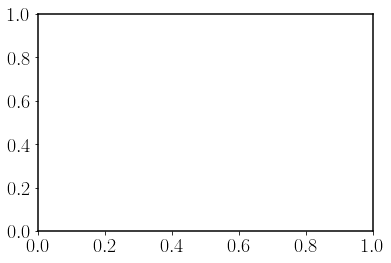

In [16]:
fig= plt.figure()
ax = fig.add_subplot()

ax.plot(hist)

O background não é linar ao longo da CCD. Aplica-se um threshold

In [ ]:
matrix = img_to_matrix(img)
matrix_threshold = threshold(matrix, 460, 0)
hist_threshold   = soma_linhas(matrix_threshold)

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

#ax3 = fig.add_subplot(2, 2, 3)
#ax4 = fig.add_subplot(2, 2, 4)

ax1.imshow(matrix)
ax1.set_title('Bkg Subtraction')
ax2.set_title('Threshold')
ax2.imshow(matrix_threshold)

ax1.plot(-400*np.array(normalize(hist))+1000, color='white')
ax2.plot(-400*np.array(normalize(hist_threshold))+1000, color='white')

for ax in [ax1, ax2]:
    ax.axis(False) 
#GUARDA IMAGEM
#imageio.imwrite('img_threshold.png', np.array(matrix_threshold).astype(np.uint16))

fig.savefig('comparison_bkg_t.pdf', bbox='tight_layout')

## Determinação do tempo de aquisição ótimo

Obtivemos vários espectros de difração, para tempos diferentes. O meu objetivo agora é perceber qual o melhor tempo a usar na nossa análise.

Para isso, vou assumir que o melhor método para remover ruído é o *Threshold* e vou fazer plot do rácio dos integrais das intensidades $\frac{Sinal}{Ruído}$, para cada tempo de aquisição.

In [17]:
matrix_threshold, bkg = threshold(matrix, 460, 0, save_bkg=True)

NameError: name 'matrix' is not defined

NameError: name 'matrix_threshold' is not defined

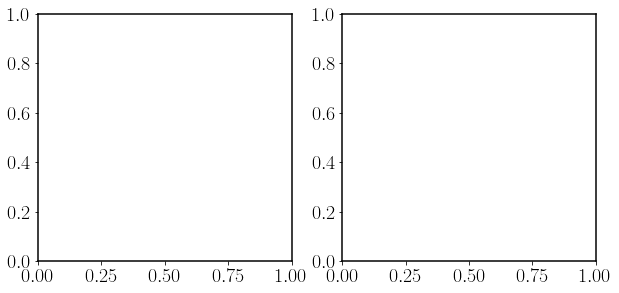

In [18]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.imshow(matrix_threshold)
ax1.set_title('Signal')
ax2.set_title('Background')
ax2.imshow(bkg)

for ax in [ax1, ax2]:
    ax.axis(False) 

In [19]:
print('Rácio = ' + str(integrate(soma_linhas(matrix_threshold))/integrate(soma_linhas(bkg))))

NameError: name 'matrix_threshold' is not defined

Aplica-se agora aos resultados obtidos

In [20]:
path_imagens = '/Users/thomasgaehtgens/Desktop/LFEA/High Harmonic Generation/Dados/3a sessao/fendas/bkg_removed_images/'
paths        = [path_imagens + str(i + 1) + 's.tif' for i in range(7)]

In [21]:
images = [Image.open(i) for i in paths]
matrxs = [img_to_matrix(i) for i in images]

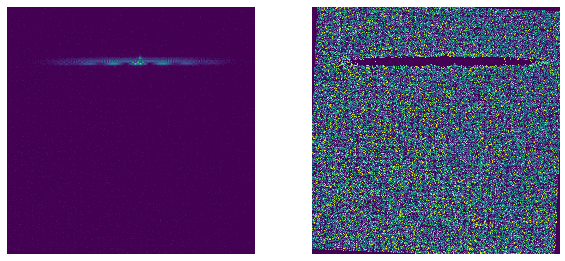

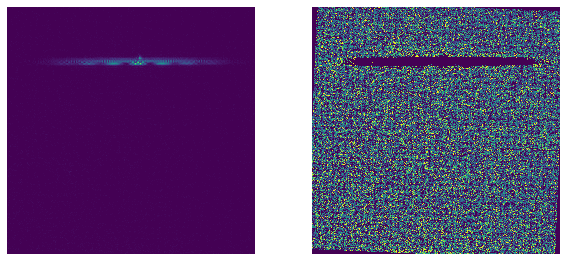

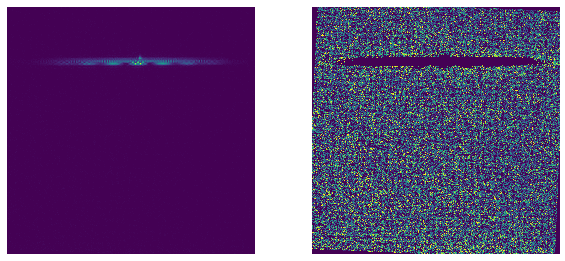

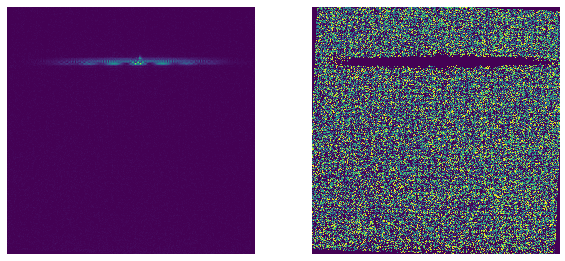

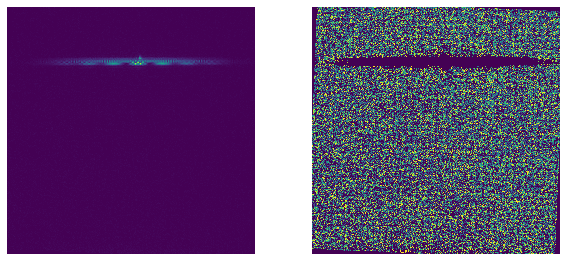

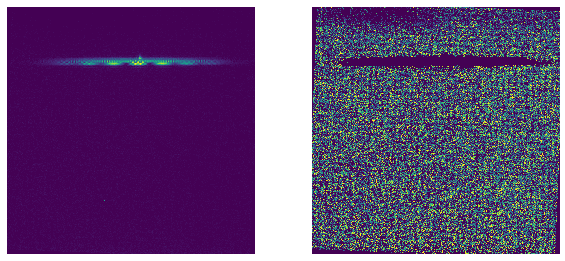

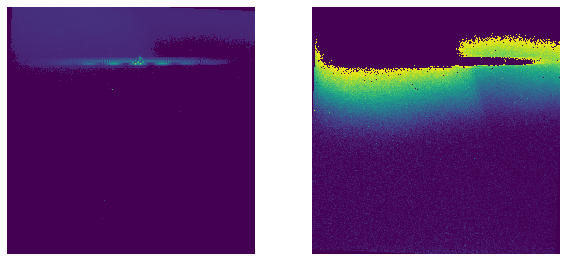

In [22]:
linhas = list()
racios = list()
t_val  = [10, 10, 10, 20, 20, 24, 350]
t_val  = [10, 10, 10, 10, 10, 10, 250]

for i in range(len(matrxs)):
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    
    new_matrix, bkg = threshold(matrxs[i], t = t_val[i], color = 0, save_bkg=True) #105 uma delas fica cute
    
    
    ax1.imshow(new_matrix)
    ax2.imshow(bkg)
    
    for ax in [ax1, ax2]:
        ax.axis(False)
        
    racios.append(integrate(soma_linhas(new_matrix))/integrate(soma_linhas(bkg)))
    linhas.append(soma_linhas(new_matrix))

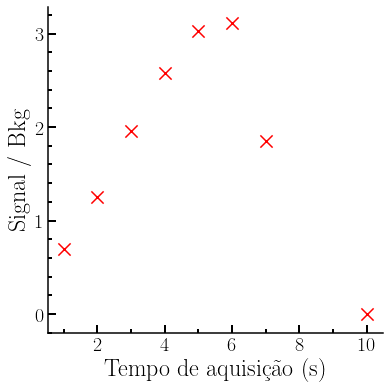

In [166]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

r = racios + [0]
ax.scatter([1, 2, 3, 4, 5, 6, 7, 10], r, color='red', s=150, marker='x')
ax.plot()

ax.set_xlabel(r'Tempo de aquisição (s)')
ax.set_ylabel(r'Signal / Bkg')

###### ESTÉTICAS ######

ax.xaxis.set_tick_params(which='major', size=8, width=2,  direction='in')
ax.xaxis.set_tick_params(which='minor', size=4, width=2,  direction='in')
ax.yaxis.set_tick_params(which='major', size=8, width=2, direction='in')
ax.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.ylim(-0.2)

plt.savefig('racios.pdf', bbox='tight_layout')

Observa-se um maior rácio para um tempo de aquisição de 6s, pelo que se escolhe o espectro correspondente para análise  

In [24]:
matrix = threshold(matrxs[-2], t = t_val[-2], color = 0, save_bkg=False) #105 uma delas fica cute

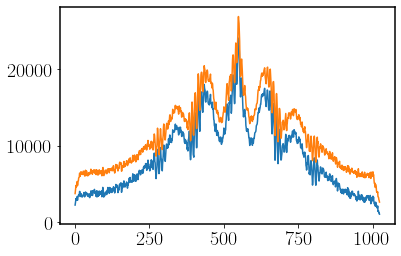

In [25]:
hist_threshold = linhas[-2]
hist           = soma_linhas(matrxs[-2])

plt.plot(hist_threshold)
plt.plot(hist)

In [26]:
N           = len(hist_threshold)
SAMPLE_RATE = 100 #Herz - frequência dos pulsos(???? NÃO SEI O QUE POR AQUI!)

yf_t = fft(hist_threshold)
yf   = fft(hist)
xf = fftfreq(N, 1/SAMPLE_RATE)

In [27]:
x_t = [x for x, _ in sorted(zip(xf, yf_t))]
y_t = [y for _, y in sorted(zip(xf, yf_t))]

x_ = [x for x, _ in sorted(zip(xf, yf))]
y_ = [y for _, y in sorted(zip(xf, yf))]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


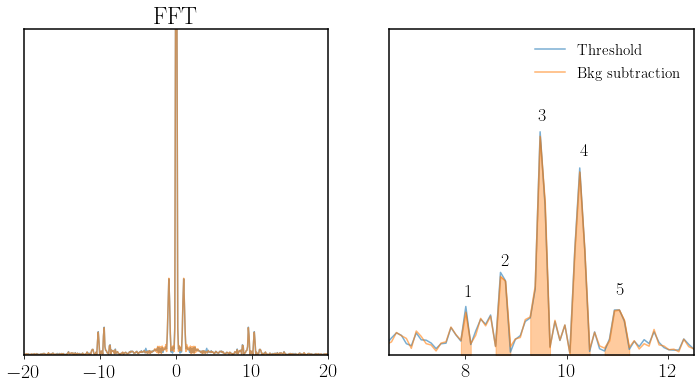

In [28]:
fig = plt.figure(figsize=(12, 6))
ax  = fig.add_subplot(1, 2, 1)

ax_section = fig.add_subplot(1, 2, 2)

ax.plot(x_t, np.abs(y_t), label='Threshold', alpha = 0.6)
ax.plot(x_, np.abs(y_),   label='Bkg subtraction', alpha = 0.6)

ax.set_xlim(-20, 20)
ax.set_ylim(0, 3200000)

ax.set_yticks([])
ax.set_title('FFT')

ax_section.plot(x_t, np.abs(y_t), label='Threshold', alpha = 0.6)
ax_section.plot(x_, np.abs(y_),   label='Bkg subtraction', alpha = 0.6)

####### ENCONTRAR OS HARMÓNICOS #######
x_h1, y_h1 = get_region(x_, y_, [7.9, 8.15])
x_h2, y_h2 = get_region(x_, y_, [8.5, 8.9])
x_h3, y_h3 = get_region(x_, y_, [9.2, 9.67])
x_h4, y_h4 = get_region(x_, y_, [10.05, 10.45])
x_h5, y_h5 = get_region(x_, y_, [10.65, 11.3])

plt.fill_between(x_h1,np.abs(y_h1), alpha = 0.4, color='C1')
plt.fill_between(x_h2,np.abs(y_h2), alpha = 0.4, color='C1')
plt.fill_between(x_h3,np.abs(y_h3), alpha = 0.4, color='C1')
plt.fill_between(x_h4,np.abs(y_h4), alpha = 0.4, color='C1')
plt.fill_between(x_h5,np.abs(y_h5), alpha = 0.4, color='C1')

#Enumeração
ax_section.text(8     , np.abs(y_h1[int(len(y_h1)/2)]) + 20000, '1', fontsize=18)
ax_section.text(8.7   , np.abs(y_h2[int(len(y_h2)/2)]) + 20000, '2', fontsize=18)
ax_section.text(9.435 , np.abs(y_h3[int(len(y_h3)/2)]) + 20000, '3', fontsize=18)
ax_section.text(10.25 , np.abs(y_h4[int(len(y_h4)/2)]) + 20000, '4', fontsize=18)
ax_section.text(10.975, np.abs(y_h5[int(len(y_h5)/2)]) + 20000, '5', fontsize=18)

#######################################

ax_section.set_yticks([])

ax_section.set_xlim(6.5, 12.5)
ax_section.set_ylim(0, 400000)

plt.legend(fontsize=15, frameon=False)

Para retirar a linha em baixo, ler [isto](https://www.kite.com/python/answers/how-to-sort-a-list-based-on-another-list-in-python)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


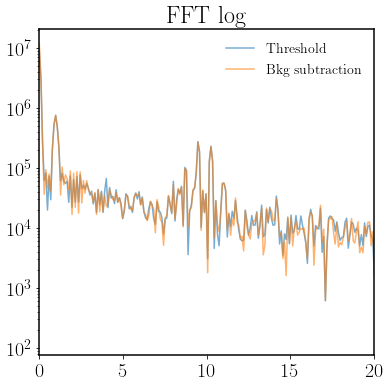

In [29]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

ax.plot(x_t, np.abs(y_t), label='Threshold', alpha = 0.6)
ax.plot(x_, np.abs(y_),   label='Bkg subtraction', alpha = 0.6)

ax.set_xlim(0, 20)
plt.yscale('log')

ax.set_title('FFT log')

plt.legend(fontsize=14, frameon=False)

O espectro obtido é composto por 3 espectro diferentes, cada um numa dada região de de y

# Separação do Espectro obtido nas suas 3 componentes

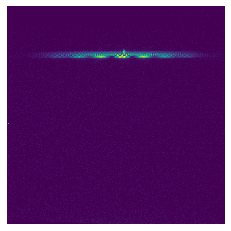

In [30]:
plt.imshow(matrix)
plt.axis(False)
plt.show()

#plt.imshow(crop(matrix, [0, len(matrix[0])], [200, 250]))
#plt.imsave('full_espectro.png', np.array(crop(matrix, [0, len(matrix[0])], [200, 250])))

In [31]:
cropped = crop(matrix, [0, len(matrix)], [200, 255])

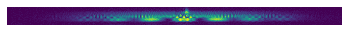

In [32]:
plt.axis(False)
plt.imshow(cropped)
plt.show()

In [33]:
linha1 = crop(cropped, [0, len(matrix)], [36, len(cropped)])

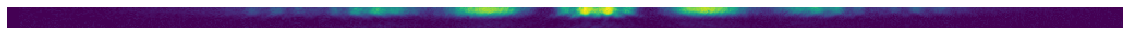

In [34]:
fig = plt.figure(figsize=(20, 1))
plt.axis(False)

plt.imshow(linha1)
plt.show()

In [35]:
linha2 = crop(cropped, [0, len(matrix)], [22, 30])

In [36]:
fig = plt.figure(figsize=(20, 1))
plt.axis(False)

plt.imshow(linha2)
plt.show()

In [37]:
linha3 = crop(cropped, [0, len(matrix)], [0, 22])

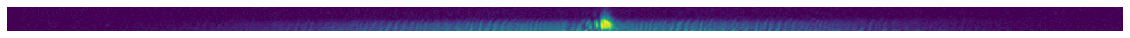

In [38]:
fig = plt.figure(figsize=(20, 1))
plt.axis(False)

plt.imshow(linha3)
plt.show()

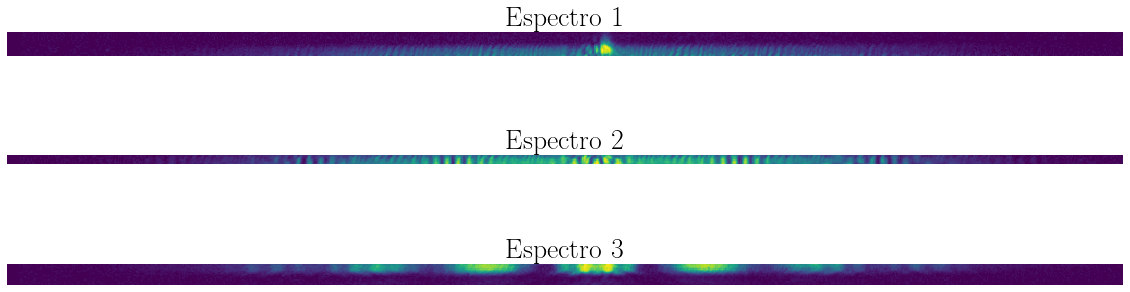

In [174]:
fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.set_title('Espectro 1', fontsize=28)
ax1.imshow(linha3)

ax2.set_title('Espectro 2', fontsize=28)
ax2.imshow(linha2)

ax3.set_title('Espectro 3', fontsize=28)
ax3.imshow(linha1)

axis = [ax1, ax2, ax3]
for ax in axis:
    ax.axis(False)
    

plt.savefig('3_Espectros.pdf', bbox='tight layout')

# Análise dos Espectros Individuais

In [149]:
#CONSTANTES
d       = 100e-6 #Distância entre fendas
delta_x = 13e-6  #Fator de conversão
z       = 40e-2  #Distância ao CCD #TEM ERRO
N       = 1024   #Pixeis
c       = 299792458

SAMPLE_RATE = (c * z)/(N * d * delta_x) # AINDA NÃO ESTOU SEGURO DA FÓRMULA

In [ ]:
erro_z  = 

In [53]:
def f_n(pixel):
    return (pixel * c * z)/(N * d * delta_x)

In [54]:
hist1 = soma_linhas(linha1)
hist2 = soma_linhas(linha2)
hist3 = soma_linhas(linha3)

hist1f = np.abs(fft(hist1))
hist2f = np.abs(fft(hist2))
hist3f = np.abs(fft(hist3))

## Espectro 2 (Apresentar em nanometros) e por o gráfico dos c.o. que passam, para poder mandar kel zoom no plot do espectro

\begin{tabular}{|c|c|c|}\n \hline Pico $\#$ & Frequência $\pm 0.05$ (PHz) & Harmónica \\
\hline 1 & $8.06e+15$ & 21.51 \\
\hline 2 & $8.73e+15$ & 23.31 \\
\hline 3 & $9.46e+15$ & 25.23 \\
\hline 4 & $1.02e+16$ & 27.11 \\
\hline
\end{tabular}


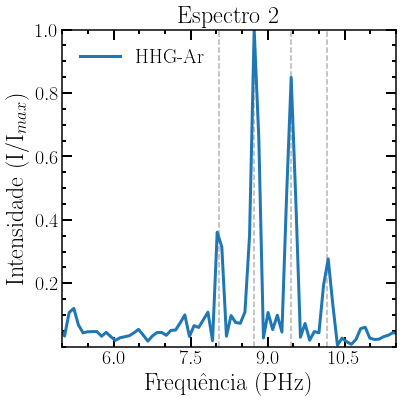

In [175]:
#ESPECÍFICO ESPECTRO 2
d   = 100e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15
#PARTE DO PLPOT
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

#A DETERMINAÇÃO DESTES VALORES TEM DE SER FEITA À MÃO
a1, b1 = 88, 92 # PICO 1
a2, b2 = 94, 100  # PICO 2
a3, b3 = 103, 108 # PICO 3
a4, b4 = 111, 116 # PICO 4

a5, b5 = 144, 149 # PICO 5
a6, b6 = 155, 161 # PICO 6
a7, b7 = 165, 173 # PICO 7

a8 , b8  = 222, 227  # PICO 8 
a9 , b9  = 241, 246 # PICO 9 
a10, b10 = 261, 265 # PICO 10

picos = [(a1, b1 ),
         (a2, b2 ),
         (a3, b3 ),
         (a4, b4 )]
         #(a5, b5 ),
         #(a6, b6 ),
         #(a7, b7 ),
         #(a8 , b8 ),
         #(a9 , b9 ),
         #(a10, b10)]

#PLOT DO ESPECTRO
ax.plot(x_f[4:int(1024/2)], normalize(hist2f[4:int(1024/2)]), '-', lw=3, label='HHG-Ar')
#HIGHLIGHT DOS HARMÓNICOS
#ax.plot(x_f[a1:b1], normalize(hist2f[a1:b1], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2, label='Picos')
#ax.plot(x_f[a2:b2], normalize(hist2f[a2:b2], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a3:b3], normalize(hist2f[a3:b3], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a4:b4], normalize(hist2f[a4:b4], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#
#ax.plot(x_f[a5:b5], normalize(hist2f[a5:b5], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a6:b6], normalize(hist2f[a6:b6], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a7:b7], normalize(hist2f[a7:b7], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)

#ax.plot(x_f[a8:b8]  , normalize(hist2f[a8:b8]  , max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a9:b9]  , normalize(hist2f[a9:b9]  , max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#ax.plot(x_f[a10:b10], normalize(hist2f[a10:b10], max(hist2f[4:int(1024/2)])), '-', color = 'salmon', lw=2)
#PLOT DA LINHA VERTICAL QUE PASSA NO CENTROIDE

HH_freq = list()
for pico in picos:
    HH_freq.append(centroid(x_f[pico[0]:pico[1]], hist2f[pico[0]:pico[1]]))
    plt.vlines(HH_freq[-1], 0, 1, linestyles='--', alpha = 0.3)

ax.set_xlabel('Frequência (PHz)')
ax.set_ylabel('Intensidade (I/I$_{max}$)')
ax.set_title('Espectro 2')
ax.legend(loc='upper left', frameon=False)

ax.set_xlim(5, 11.5)
ax.set_ylim(0, 1)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')

ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))

ax.yaxis.set_major_locator(MaxNLocator(prune='lower', nbins=5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
        
print_tabular(np.array(HH_freq)*1e15, LaTeX=True) #LaTeX = True ---> LaTeX print

fig.set_tight_layout(True)
plt.savefig('Ar_spec2.pdf', bbox='tight_layout')

## Espectro 3 (Apresentar em nanometros)

\begin{tabular}{|c|c|c|}\n \hline Pico $\#$ & Frequência $\pm 0.05$ (PHz) & Harmónica \\
\hline 1 & $8.61e+15$ & 22.98 \\
\hline
\end{tabular}


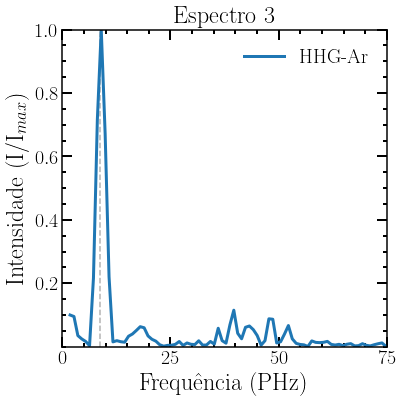

In [165]:
#ESPECÍFICO ESPECTRO 3
d   = 10e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15

#PARTE DO PLPOT
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot()

#A DETERMINAÇÃO DESTES VALORES TEM DE SER FEITA À MÃO
a1, b1 = 7, 14 # PICO 1
#a2, b2 = 16, 26 # PICO 1
# ...
picos = [(a1, b1 )]#, (a2, b2)]

#PLOT DO ESPECTRO
ax.plot(x_f[2:int(1024/2)], normalize(hist1f[2:int(1024/2)]), '-', lw=3, label='HHG-Ar')
#HIGHLIGHT DOS HARMÓNICOS
#ax.plot(x_f[a1:b1], normalize(hist1f[a1:b1], max(hist1f[2:int(1024/2)])), '-', color = 'salmon', lw=2, label='Picos')
#ax.plot(x_f[a2:b2], normalize(hist1f[a2:b2], max(hist1f[2:int(1024/2)])), '-', color = 'salmon', lw=2, label='Picos')

#PLOT DA LINHA VERTICAL QUE PASSA NO CENTROIDE

HH_freq = list()
for pico in picos:
    HH_freq.append(centroid(x_f[pico[0]:pico[1]], hist2f[pico[0]:pico[1]]))
    plt.vlines(HH_freq[-1], 0, 1, linestyles='--', alpha = 0.3)

ax.set_xlabel('Frequência (PHz)')
ax.set_ylabel(r'Intensidade (I/I$_{max}$)')
ax.set_title('Espectro 3')
ax.legend(loc='upper right', frameon=False)
#
ax.set_xlim(0, 75)
#ax.set_xlim(7, 11)
ax.set_ylim(0, 1)
#
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
#
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')
#
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
#
ax.yaxis.set_major_locator(MaxNLocator(prune='lower', nbins=5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
#        
print_tabular(np.array(HH_freq)*1e15, LaTeX=True) #LaTeX = True ---> LaTeX print

fig.set_tight_layout(True)
plt.savefig('Ar_spec3.pdf', bbox='tight_layout')

# PLOT EXEMPLO

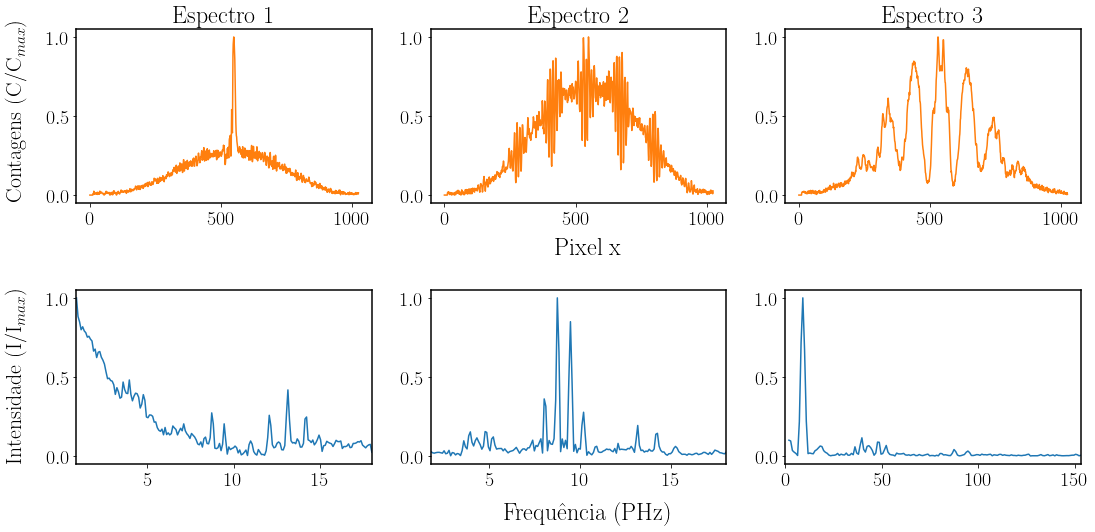

In [176]:
fig = plt.figure(figsize=(18, 8))

#ESPECÍFICO ESPECTRO 2
d   = 100e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15

#Sinal
ax1  = fig.add_subplot(2, 3, 1)
ax2  = fig.add_subplot(2, 3, 2)
ax3  = fig.add_subplot(2, 3, 3)
#Transfomada
ax1f = fig.add_subplot(2, 3, 4)
ax2f = fig.add_subplot(2, 3, 5)
ax3f = fig.add_subplot(2, 3, 6)

ax1.set_title('Espectro 1')
ax1.plot(normalize(hist3), color='C1')

ax2.set_title('Espectro 2')
ax2.plot(normalize(hist2), color='C1')

ax3.set_title('Espectro 3')
ax3.plot(normalize(hist1), color='C1')

ax1f.plot(x_f[10:int(1024/2)], normalize(hist3f[10:int(1024/2)]), color='C0')
ax2f.plot(x_f[10:int(1024/2)], normalize(hist2f[10:int(1024/2)]), color='C0')

ax1f.set_xlim(x_f[10], x_f[200])
ax2f.set_xlim(x_f[20], x_f[200])

#ESPECÍFICO ESPECTRO 3

d   = 10e-6 #Distância entre fendas
x_f = f_n(np.linspace(0, 1023, 1024))*1e-15
ax3f.plot(x_f[2:int(1024/2)], normalize(hist1f[2:int(1024/2)]), color='C0')

axis = [ax1, ax2, ax3, ax1f, ax2f, ax3f]
#for ax in axis:
#    ax.axis(False)
ax3f.set_xlim(0, x_f[170])

plt.subplots_adjust(hspace = 0.5) 

fig.text(0.52, 0.5, 'Pixel x', ha='center', va='center', fontsize=24)
fig.text(0.52, 0.04, 'Frequência (PHz)', ha='center', va='center', fontsize=24)

fig.text(0.08, 0.28, 'Intensidade (I/I$_{max})$', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(0.08, 0.74, 'Contagens (C/C$_{max})$', ha='center', va='center', rotation='vertical', fontsize=22)
    
fig.savefig('AR_Specs.pdf', bbox='tight_layout')

In [ ]:
help(fft)